In [1]:
import os
import os.path
import tarfile
#import tqdm
import pickle as pkl
import random
import numpy as np
import spacy
import string
from collections import Counter
from spacy.lang.en.stop_words import STOP_WORDS

## data preprocessing

In [66]:
# read files
cwd = os.getcwd()
path = '/'.join(cwd.split('\\'))+'/'
tar = tarfile.open(path+"aclImdb_v1.tar.gz", "r")
names = tar.getnames()

train_neg_names = [a for a in names if (len(a)>17 and (a[:17]=='aclImdb/train/neg')) ]
train_pos_names = [a for a in names if (len(a)>17 and (a[:17]=='aclImdb/train/pos')) ]
test_neg_names = [a for a in names if (len(a)>16 and (a[:16]=='aclImdb/test/neg')) ]
test_pos_names = [a for a in names if (len(a)>16 and (a[:16]=='aclImdb/test/pos')) ]

#merge files and build labels
train_pos_score = []
for i in train_pos_names:
    tmp = float(i[-5:-4])
    if(tmp == 0):
        if(i[-6] == "1"):
            train_pos_score.append(10.0)
        else:
            train_pos_score.append(0)
    else:
        train_pos_score.append(tmp)
        
train_neg_score = []
for i in train_neg_names:
    tmp = float(i[-5:-4])
    if(tmp == 0):
        if(i[-6] == "1"):
            train_neg_score.append(10.0)
        else:
            train_neg_score.append(0)
    else:
        train_neg_score.append(tmp)
        
test_pos_score = []
for i in test_pos_names:
    tmp = float(i[-5:-4])
    if(tmp == 0):
        if(i[-6] == "1"):
            test_pos_score.append(10.0)
        else:
            test_pos_score.append(0)
    else:
        test_pos_score.append(tmp)
        
test_pos_score = []
for i in test_pos_names:
    tmp = float(i[-5:-4])
    if(tmp == 0):
        if(i[-6] == "1"):
            test_pos_score.append(10.0)
        else:
            test_pos_score.append(0)
    else:
        test_pos_score.append(tmp)
        
train_pos = []
for i in train_pos_names:
    tar.extract(i, path = path)
    a=open(path+i,'r',encoding = "utf-8")
    train_pos.append(a.read())
    a.close()
    os.remove(path+i)
    
train_neg = []
for i in train_neg_names:
    tar.extract(i, path = path)
    a=open(path+i,'r',encoding = "utf-8")
    train_neg.append(a.read())
    a.close()
    os.remove(path+i)

test_pos = []
for i in test_pos_names:
    tar.extract(i, path = path)
    a=open(path+i,'r',encoding = "utf-8")
    test_pos.append(a.read())
    a.close()
    os.remove(path+i)
    
test_neg = []
for i in test_neg_names:
    tar.extract(i, path = path)
    a=open(path+i,'r',encoding = "utf-8")
    test_neg.append(a.read())
    a.close()
    os.remove(path+i)

train_label = [1] * len(train_pos) +[0] * len(train_neg)
train = train_pos + train_neg
label_test = [1] * len(test_pos) +[0] * len(test_neg)
data_test = test_pos + test_neg
train_score = train_pos_score + train_neg_score
score_test = test_pos_score +test_neg_score

# split training/validation sets
val_index = random.sample(range(len(train)), 5000)
train_index = list(set(range(len(train))) - set(val_index))
data_val = np.array(train)[val_index]
label_val = np.array(train_label)[val_index]
data_train = np.array(train)[train_index]
label_train = np.array(train_label)[train_index]
score_val = np.array(train_score)[val_index]
score_train = np.array(train_score)[train_index]

In [135]:
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens]

In [136]:
def tokenize_dataset(dataset, n_gram=1, punctuation=True, stop_word=True):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(str(sample))
        if(stop_word):
            tokens_filter = [token for token in tokens if ((token not in punctuations) and (token not in STOP_WORDS))]
        elif(punctuation):
            tokens_filter = [token for token in tokens if (token not in punctuations)]
        else:
            tokens_filter = tokens
        all_tokens += tokens_filter
        tokens_num = len(tokens)
        for k in range(1,4):
            if(n_gram > k):
                for i in range(0, tokens_num-k):
                    tokens_filter.append(" ".join(tokens[i:(i+k+1)]))
                    all_tokens += [" ".join(tokens[i:(i+k+1)])]
        token_dataset.append(tokens_filter)
    return token_dataset, all_tokens

In [626]:
#tokenization
print ("Tokenizing val data")
val_data_tokens, _ = tokenize_dataset(data_val, 2)
pkl.dump(val_data_tokens, open("val_data_tokens_2gram_hw1.p", "wb"))

print ("Tokenizing train data")
train_data_tokens, all_train_tokens = tokenize_dataset(data_train, 2)
pkl.dump(train_data_tokens, open("train_data_tokens_2gram_hw1.p", "wb"))
pkl.dump(all_train_tokens, open("all_train_tokens_2gram_hw1.p", "wb"))

print("Tokenizing test data")
test_data_tokens, _ = tokenize_dataset(data_test, 2)
pkl.dump(test_data_tokens, open("test_data_tokens_2gram_hw1.p", "wb"))

Tokenizing val data
Tokenizing train data
Tokenizing test data


In [4]:
#check size of tokened files
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))
print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 7720323


In [5]:
max_vocab_size = 25000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)

In [6]:
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000


## Predicting Sentiment

In [75]:
MAX_SENTENCE_LENGTH = 600

import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)).long(), torch.LongTensor(length_list), torch.LongTensor(label_list)]

BATCH_SIZE = 50
train_dataset = NewsGroupDataset(train_data_indices, label_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, label_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

test_dataset = NewsGroupDataset(test_data_indices, label_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear1 = nn.Linear(emb_dim, 2)
        #self.dropout = nn.Dropout(p=1 - nodropout_probability)
        #self.linear2 = nn.Linear(200, 2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear1(out)
        #out = F.softmax(out, dim=1)
        #out = self.dropout(out)
        #out = self.linear2(out)
        out = F.log_softmax(out, dim=1)
        return out



In [77]:
#set hyperparameters
emb_dim = 400
learning_rate = 0.001
num_epochs = 20
nodropout_probability = 0.8
model = BagOfWords(len(id2token), emb_dim)

In [78]:
def do_train(model, dataloader, criterion, optimizer):
    model.train()
    train_loss = 0
    for data, lengths, labels in dataloader:
        optimizer.zero_grad()
        y_hat = model(data, lengths)
        loss = criterion(y_hat, labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(data) / len(dataloader.dataset)
    return train_loss

def do_eval(model, dataloader):
    model.eval()
    y_ls = []
    y_hat_ls = []
    val_loss = 0
    with torch.no_grad():
        for data, lengths, labels in dataloader:
            y_hat = model(data, lengths)
            loss = criterion(y_hat, labels.long())
            y_hat_ls.append(y_hat)
            y_ls.append(labels)
            val_loss += loss.item() * len(data) / len(dataloader.dataset)
    optimizer.zero_grad()
    return val_loss, torch.cat(y_hat_ls, dim=0), torch.cat(y_ls, dim=0)

def acc(model, dataloader):
    val_loss, pred,true = do_eval(
    model = model,
    dataloader = dataloader,
    )
    return val_loss, (torch.exp(pred).max(1)[1] == true).float().mean().item()

In [79]:

#lambda1 = lambda epoch: 1-0.1*epoch
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
loss_train = []
loss_val = []
acc_val = []
for epoch in range(num_epochs):
    #scheduler.step()
    loss = do_train(
        model=model, 
        criterion=criterion,
        dataloader=train_loader,
        optimizer=optimizer,
    )
    loss_train.append(loss)
    val_loss, val_acc = acc(model, val_loader)
    loss_val.append(val_loss)
    acc_val.append(val_acc)
    print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                       epoch+1, num_epochs, loss, val_loss, val_acc))


Epoch: [1/20], Train Loss: 0.58800151117146, Val Loss: 0.43902601927518864, Val Acc: 0.8507999777793884
Epoch: [2/20], Train Loss: 0.3302837342768907, Val Loss: 0.3246617384254933, Val Acc: 0.8596000075340271
Epoch: [3/20], Train Loss: 0.22958611501380816, Val Loss: 0.2668018152564764, Val Acc: 0.8881999850273132
Epoch: [4/20], Train Loss: 0.17660969797521822, Val Loss: 0.24642023988068104, Val Acc: 0.899399995803833
Epoch: [5/20], Train Loss: 0.13879054923541836, Val Loss: 0.24139636933803552, Val Acc: 0.9014000296592712
Epoch: [6/20], Train Loss: 0.1081599530577661, Val Loss: 0.24224533289670935, Val Acc: 0.902999997138977
Epoch: [7/20], Train Loss: 0.08459293858148159, Val Loss: 0.24805443465709684, Val Acc: 0.9046000242233276
Epoch: [8/20], Train Loss: 0.0650572704616934, Val Loss: 0.2544720259308815, Val Acc: 0.9043999910354614
Epoch: [9/20], Train Loss: 0.049707852911669854, Val Loss: 0.26447165437042713, Val Acc: 0.902999997138977
Epoch: [10/20], Train Loss: 0.037948018923634676

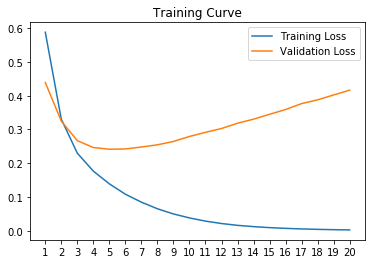

In [80]:
import matplotlib.pyplot as plt
#plot training curve
plt.figure(figsize=(15, 10))
plt.plot(range(1, len(loss_train)+1), loss_train, label="Training Loss")
plt.plot(range(1, len(loss_val)+1), loss_val, label="Validation Loss")
plt.xticks(range(1, len(loss_val)+1))
#plt.ylim(0,0.7)
plt.legend()
plt.title("Training Curve")
plt.show()

In [81]:
#early stopping
model = BagOfWords(len(id2token), emb_dim)
#lambda1 = lambda epoch: 1-0.1*epoch
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
loss_train = []
loss_val = []
acc_val = []
for epoch in range(5):
    #scheduler.step()
    loss = do_train(
        model=model, 
        criterion=criterion,
        dataloader=train_loader,
        optimizer=optimizer,
    )
    loss_train.append(loss)
    val_loss, val_acc = acc(model, val_loader)
    loss_val.append(val_loss)
    acc_val.append(val_acc)
    print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                       epoch+1, num_epochs, loss, val_loss, val_acc))


Epoch: [1/20], Train Loss: 0.6003804549574854, Val Loss: 0.4617471018433568, Val Acc: 0.8361999988555908
Epoch: [2/20], Train Loss: 0.34190539460629216, Val Loss: 0.30558265209197993, Val Acc: 0.8845999836921692
Epoch: [3/20], Train Loss: 0.23323464967310434, Val Loss: 0.26597335845232023, Val Acc: 0.8978000283241272
Epoch: [4/20], Train Loss: 0.1794719515368343, Val Loss: 0.24953824207186692, Val Acc: 0.8985999822616577
Epoch: [5/20], Train Loss: 0.14063933039084084, Val Loss: 0.2428997721523046, Val Acc: 0.9031999707221985


In [83]:
# test accuracy
print ("After training for {} epochs".format(5))
print ("Test Acc {}".format(acc(model, test_loader)[1]))

After training for 5 epochs
Test Acc 0.8970800042152405


In [96]:
#three correct and incorrect case in the validation set
_, pred,true = do_eval(model, val_loader)
judge = (torch.exp(pred).max(1)[1] == true).numpy()
print("3 correct case")
print(data_val[judge==1][:3])
judge = (torch.exp(pred).max(1)[1] == true).numpy()
print("3 incorrect case")
print(data_val[judge==0][:3])

3 correct case
['Loony Tunes have ventured (at least) twice into the future. The first time was with the brilliantly funny "Duck Dodgers". The latter time was with this \x85 um \x85 effort. "Loonatics Unleashed" isn\'t without merit, and might be considered a good product were it not that it isn\'t up to Warner Brothers quality. WB cartoons are noted for their cheeky humor, appealing at least as much to adults as to children. These pedestrian superhero episodes, on the other hand, cannot fail to convince adults to pass them up.<br /><br />The premise of the series is that 6 ordinary individuals (2 bunnies, a Tasmanian devil, a duck, a roadrunner, and a coyote) live on the "city-planet" of Acmetropolis and acquire super powers when a meteor strikes the planet in 2772. What\'s confusing is that the titles section features these individuals with a count-up to 2772 from the 21st Century. Cute, but frelling stupid.<br /><br />In each episode, the super sextet \x96 amid mildly amusing but es

## Predicting Scores

In [13]:
MAX_SENTENCE_LENGTH = 600

import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)).long(), torch.LongTensor(length_list), torch.LongTensor(label_list)]

BATCH_SIZE = 50
train_dataset = NewsGroupDataset(train_data_indices, score_train-1)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, score_val-1)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

test_dataset = NewsGroupDataset(test_data_indices, np.array(score_test)-1)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)


In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear1 = nn.Linear(emb_dim, 10)
        self.dropout = nn.Dropout(p=1 - nodropout_probability)
        self.linear2 = nn.Linear(200, 10)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear1(out)
        #out = F.softmax(out, dim=1)
        #out = self.dropout(out)
        #out = self.linear2(out)
        out = F.log_softmax(out, dim=1)
        return out

emb_dim = 600

In [56]:
learning_rate = 0.001
num_epochs = 20
nodropout_probability = 0.6
model = BagOfWords(len(id2token), emb_dim)

In [57]:
def do_train(model, dataloader, criterion, optimizer):
    global y_hat
    model.train()
    train_loss = 0
    for data, lengths, labels in dataloader:
        optimizer.zero_grad()
        y_hat = model(data, lengths)
        loss = criterion(y_hat, labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(data) / len(dataloader.dataset)
    return train_loss

def do_eval(model, dataloader):
    model.eval()
    y_ls = []
    y_hat_ls = []
    val_loss = 0
    with torch.no_grad():
        for data, lengths, labels in dataloader:
            y_hat = model(data, lengths)
            loss = criterion(y_hat, labels.long())
            y_hat_ls.append(y_hat)
            y_ls.append(labels)
            val_loss += loss.item() * len(data) / len(dataloader.dataset)
    optimizer.zero_grad()
    return val_loss, torch.cat(y_hat_ls, dim=0), torch.cat(y_ls, dim=0)

def acc(model, dataloader):
    val_loss, pred,true = do_eval(
    model = model,
    dataloader = dataloader,
    )
    return val_loss, (torch.exp(pred).max(1)[1] == true).float().mean().item()

In [58]:
#lambda1 = lambda epoch: 1-0.1*epoch
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
loss_train = []
loss_val = []
acc_val = []
for epoch in range(num_epochs):
    #scheduler.step()
    loss = do_train(
        model=model, 
        criterion=criterion,
        dataloader=train_loader,
        optimizer=optimizer,
    )
    loss_train.append(loss)
    val_loss, val_acc = acc(model, val_loader)
    loss_val.append(val_loss)
    acc_val.append(val_acc)
    print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                       epoch+1, num_epochs, loss, val_loss, val_acc))

Epoch: [1/20], Train Loss: 1.9865798291563994, Val Loss: 1.8747088277339936, Val Acc: 0.35339999198913574
Epoch: [2/20], Train Loss: 1.7045972469449058, Val Loss: 1.6225536322593692, Val Acc: 0.39259999990463257
Epoch: [3/20], Train Loss: 1.4811328124999996, Val Loss: 1.517610048055648, Val Acc: 0.42260000109672546
Epoch: [4/20], Train Loss: 1.3398952871561043, Val Loss: 1.4598029404878607, Val Acc: 0.44179999828338623
Epoch: [5/20], Train Loss: 1.2305912639200687, Val Loss: 1.4596172219514842, Val Acc: 0.42899999022483826
Epoch: [6/20], Train Loss: 1.1205519209802157, Val Loss: 1.427342021465301, Val Acc: 0.4413999915122986
Epoch: [7/20], Train Loss: 1.016979096233845, Val Loss: 1.4314233094453817, Val Acc: 0.4415999948978424
Epoch: [8/20], Train Loss: 0.9115160684287547, Val Loss: 1.4410927134752276, Val Acc: 0.4408000111579895
Epoch: [9/20], Train Loss: 0.8085804544389247, Val Loss: 1.4640153884887692, Val Acc: 0.4350000023841858
Epoch: [10/20], Train Loss: 0.7037753657996655, Val L

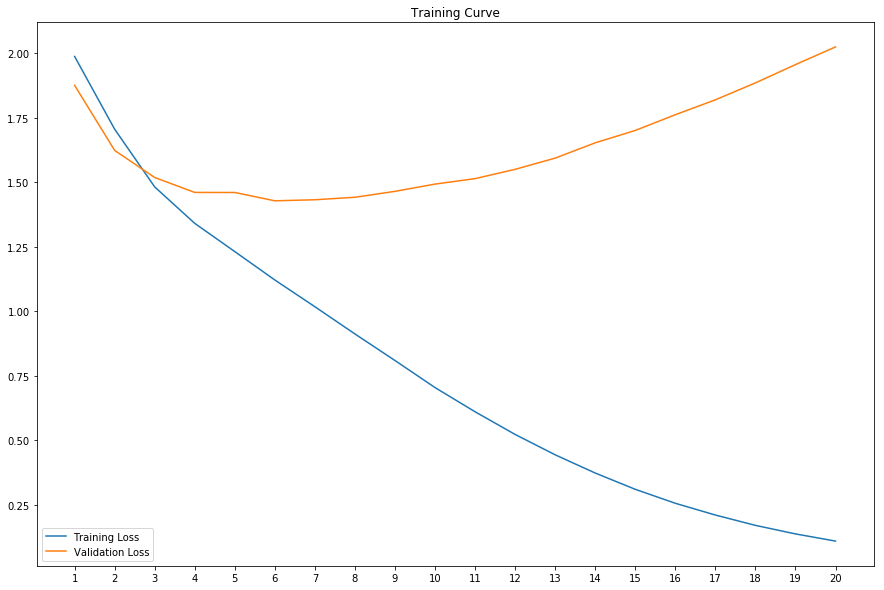

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.plot(range(1, len(loss_train)+1), loss_train, label="Training Loss")
plt.plot(range(1, len(loss_val)+1), loss_val, label="Validation Loss")
plt.xticks(range(1, len(loss_val)+1))
#plt.ylim(0,0.7)
plt.legend()
plt.title("Training Curve")
plt.show()

In [63]:
model = BagOfWords(len(id2token), emb_dim)
#lambda1 = lambda epoch: 1-0.1*epoch
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
loss_train = []
loss_val = []
acc_val = []
for epoch in range(6):
    #scheduler.step()
    loss = do_train(
        model=model, 
        criterion=criterion,
        dataloader=train_loader,
        optimizer=optimizer,
    )
    loss_train.append(loss)
    val_loss, val_acc = acc(model, val_loader)
    loss_val.append(val_loss)
    acc_val.append(val_acc)
    print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                       epoch+1, num_epochs, loss, val_loss, val_acc))

Epoch: [1/20], Train Loss: 1.984321683645248, Val Loss: 1.8721805524826045, Val Acc: 0.3140000104904175
Epoch: [2/20], Train Loss: 1.7011786177754418, Val Loss: 1.6252579700946803, Val Acc: 0.39800000190734863
Epoch: [3/20], Train Loss: 1.4836363396048535, Val Loss: 1.5096246957778925, Val Acc: 0.43220001459121704
Epoch: [4/20], Train Loss: 1.3414069819450378, Val Loss: 1.4609384101629264, Val Acc: 0.44519999623298645
Epoch: [5/20], Train Loss: 1.2261995701491823, Val Loss: 1.4332348948717122, Val Acc: 0.4472000002861023
Epoch: [6/20], Train Loss: 1.1188027209043516, Val Loss: 1.4226779758930206, Val Acc: 0.4447999894618988


In [65]:
_, pred,true = do_eval(
    model = model,
    dataloader = test_loader,
    )
print("Test Accuracy: {}".format((torch.exp(pred).max(1)[1] == true).float().mean().item()))
print("Top 3 Test Accuracy: {}".format(((torch.exp(pred).max(1)[1] <= true+1) & (torch.exp(pred).max(1)[1] >= true-1)).float().mean().item()))

Test Accuracy: 0.44196000695228577
Top 3 Test Accuracy: 0.6912400126457214
